# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# TabNet library
#
from pytorch_tabnet.tab_model import TabNetRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [4]:
Lag        =   12
Horizon    =    4

# Data handling

## Import data


In [5]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.30 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [6]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-02-19 00:00:00,2.457895
2022-02-19 00:05:00,2.494737
2022-02-19 00:10:00,2.494737


In [7]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [8]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

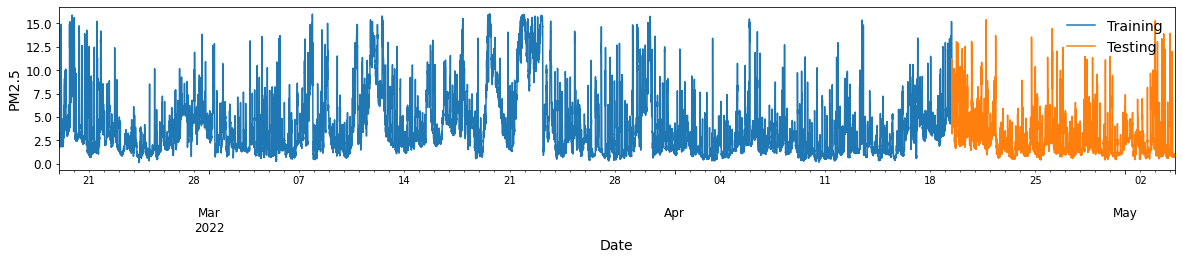

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [10]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [11]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(-df.min().min(), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [12]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [13]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ][i:(i+Lag-1)]).to_list()
#         # Time
#         Instance.append( df.index[i+Lag-1].hour + df.index[i+Lag-1].minute / 60) 
        # Current value
        Instance.append( df[ targetSeries ].to_numpy()[i+Lag-1] )

           
        

        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY) )

In [14]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 4277/4277 [00:00<00:00, 5221.12it/s]

Training instances:     4276
Testing instances:      4277


In [15]:
trainX.shape, trainY.shape

((4276, 12), (4276, 4))

# Forecasting model: TabNet

## Setup model

In [16]:
model = TabNetRegressor(verbose = 1, 
                        seed    = 42)

Device used : cpu


## Training process

In [17]:
import torch.nn as nn

# Start clock
#
start = time.time()

# Train model
#
model.fit(X_train = trainX, 
          y_train = trainY,
          loss_fn = nn.MSELoss(), # nn.L1Loss(), nn.MSELoss()
          #
          eval_set    = [(testX, testY)],
          batch_size  = 32,
          num_workers = 0,
          patience    = 200, 
          max_epochs  = 2000,
          eval_metric = ['rmse'])

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

epoch 0  | loss: 0.25965 | val_0_rmse: 0.5348  |  0:00:02s
epoch 1  | loss: 0.21243 | val_0_rmse: 0.5213  |  0:00:05s
epoch 2  | loss: 0.21099 | val_0_rmse: 0.5248  |  0:00:08s
epoch 3  | loss: 0.21019 | val_0_rmse: 0.51217 |  0:00:10s
epoch 4  | loss: 0.20911 | val_0_rmse: 0.50918 |  0:00:13s
epoch 5  | loss: 0.2062  | val_0_rmse: 0.51357 |  0:00:16s
epoch 6  | loss: 0.20466 | val_0_rmse: 0.50531 |  0:00:18s
epoch 7  | loss: 0.20577 | val_0_rmse: 0.5135  |  0:00:21s
epoch 8  | loss: 0.20498 | val_0_rmse: 0.50333 |  0:00:23s
epoch 9  | loss: 0.20408 | val_0_rmse: 0.5084  |  0:00:26s
epoch 10 | loss: 0.20604 | val_0_rmse: 0.50871 |  0:00:29s
epoch 11 | loss: 0.20636 | val_0_rmse: 0.50429 |  0:00:32s
epoch 12 | loss: 0.20467 | val_0_rmse: 0.50915 |  0:00:34s
epoch 13 | loss: 0.2037  | val_0_rmse: 0.50385 |  0:00:37s
epoch 14 | loss: 0.20382 | val_0_rmse: 0.50817 |  0:00:39s
epoch 15 | loss: 0.20208 | val_0_rmse: 0.50419 |  0:00:42s
epoch 16 | loss: 0.20083 | val_0_rmse: 0.50507 |  0:00:4

epoch 139| loss: 0.2     | val_0_rmse: 0.50421 |  0:06:46s
epoch 140| loss: 0.1996  | val_0_rmse: 0.5034  |  0:06:48s
epoch 141| loss: 0.20111 | val_0_rmse: 0.50772 |  0:06:51s
epoch 142| loss: 0.19996 | val_0_rmse: 0.50599 |  0:06:53s
epoch 143| loss: 0.20211 | val_0_rmse: 0.50401 |  0:06:56s
epoch 144| loss: 0.20158 | val_0_rmse: 0.5056  |  0:06:58s
epoch 145| loss: 0.20067 | val_0_rmse: 0.50942 |  0:07:01s
epoch 146| loss: 0.19975 | val_0_rmse: 0.50804 |  0:07:03s
epoch 147| loss: 0.20196 | val_0_rmse: 0.50247 |  0:07:06s
epoch 148| loss: 0.19884 | val_0_rmse: 0.5045  |  0:07:08s
epoch 149| loss: 0.20023 | val_0_rmse: 0.51179 |  0:07:11s
epoch 150| loss: 0.20152 | val_0_rmse: 0.50168 |  0:07:14s
epoch 151| loss: 0.20082 | val_0_rmse: 0.50979 |  0:07:16s
epoch 152| loss: 0.19896 | val_0_rmse: 0.50772 |  0:07:19s
epoch 153| loss: 0.19994 | val_0_rmse: 0.53321 |  0:07:21s
epoch 154| loss: 0.20069 | val_0_rmse: 0.50452 |  0:07:24s
epoch 155| loss: 0.20038 | val_0_rmse: 0.50657 |  0:07:2

epoch 278| loss: 0.20081 | val_0_rmse: 0.52706 |  0:13:13s
epoch 279| loss: 0.1989  | val_0_rmse: 0.50372 |  0:13:17s
epoch 280| loss: 0.19933 | val_0_rmse: 0.50601 |  0:13:22s

Early stopping occurred at epoch 280 with best_epoch = 80 and best_val_0_rmse = 0.50056
Best weights from best epoch are automatically used!
[INFO] Time 802.89


## Evaluation

### Get predictions

In [18]:
# Get predictions
#
pred = model.predict( testX )


### Inverse "Lag-d Diff" transformation

In [19]:
for i in range( Horizon ):
    testY[:, i] = testX[:, -1] - testY[:, i]
    pred[:, i]  = testX[:, -1] - pred[:, i]

### Apply inverse scaling/transformation

In [20]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [21]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i]   



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.57 SMAPE: 18.34 R2: 0.73
Horizon:  2 MAE  0.80 SMAPE: 25.88 R2: 0.51
Horizon:  3 MAE  0.92 SMAPE: 30.79 R2: 0.39
Horizon:  4 MAE  1.00 SMAPE: 34.20 R2: 0.32


In [22]:
# PM2.5 + Time
# ------------------------------------------------
# Horizon:  1 MAE  0.58 SMAPE: 18.92 R2: 0.73
# Horizon:  2 MAE  0.81 SMAPE: 26.66 R2: 0.51
# Horizon:  3 MAE  0.94 SMAPE: 31.70 R2: 0.39
# Horizon:  4 MAE  1.03 SMAPE: 35.75 R2: 0.32


# PM2.5
# ------------------------------------------------
# Horizon:  1 MAE  0.57 SMAPE: 18.34 R2: 0.73
# Horizon:  2 MAE  0.80 SMAPE: 25.88 R2: 0.51
# Horizon:  3 MAE  0.92 SMAPE: 30.79 R2: 0.39
# Horizon:  4 MAE  1.00 SMAPE: 34.20 R2: 0.32

## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


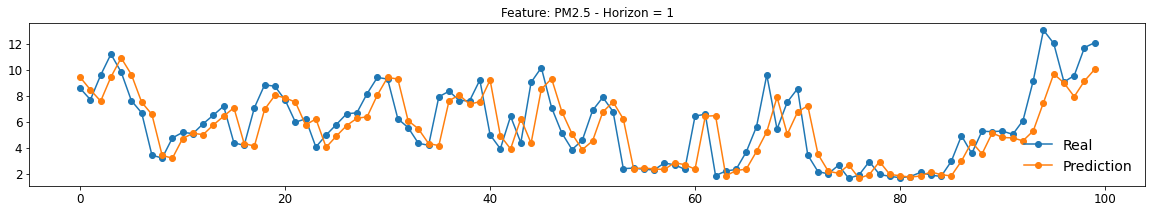

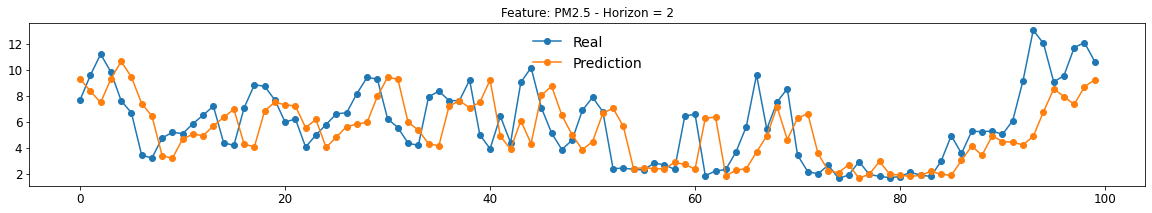

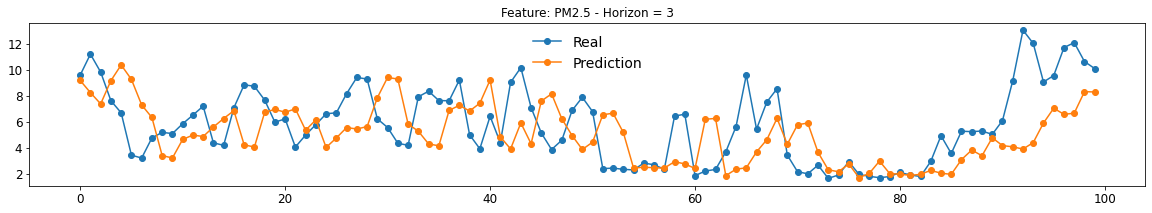

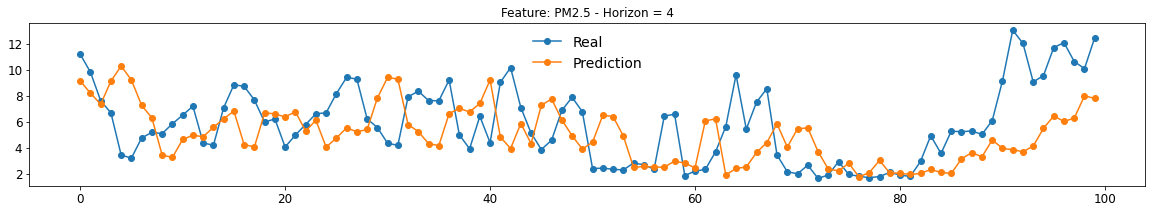

In [23]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i] 
    Prices['Prediction'] = pred[:, i] 
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

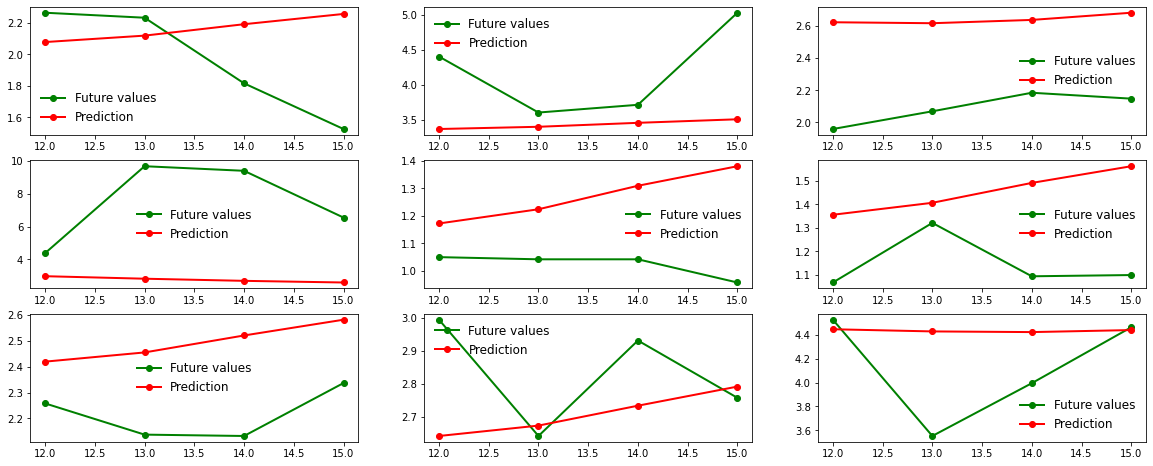

In [24]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [26]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries]  = testY.flatten()
Outputs['TabNet_diff'] = pred.flatten()
#
#
Outputs.to_csv('Predictions/TabNet_diff.csv')